# Лабораторная работа №6
https://pykeen.readthedocs.io/en/stable/api/pykeen.datasets.Countries.html

Работу выполнили:

Расковалова Алёна, P4241
Строкова Анастасия, P4240

## Link Prediction
**Link Prediction** (предсказание связей) - это задача в области графовых знаний, направленная на предсказание отношений (рёбер) между сущностями в графовой структуре. В контексте баз данных знаний, где информация представлена в виде графа, задача link prediction становится важным инструментом для дополнения или обновления существующей сети отношений.

Задача link prediction заключается в предсказании отсутствующих рёбер между сущностями, основываясь на известных связях в графе.

Применения link prediction включают:

> Предсказание новых связей между пользователями или группами.

> Предсказание взаимодействий между белками в биологических сетях.

> Предсказание связей между пользователями и товарами.

> Пополнение базы знаний новыми фактами.

В контексте машинного обучения и графовых моделей, задача link prediction решается с использованием методов, таких как графовые эмбеддинги, глубокие нейронные сети, и другие алгоритмы, специфичные для графовых данных.

### Установка зависимостей


Устанавливаем необходимые для работы зависимости

In [ ]:
!pip install pykeen matplotlib

Далее, импортируем необходимых модулей

In [5]:
import pykeen
import torch
import matplotlib.pyplot as plt
from pykeen.pipeline import pipeline
from pykeen.evaluation import ClassificationEvaluator
from pykeen.datasets import Countries

В этой работе мы снова будем использовать уже известный dataset Countries

In [6]:
# Загрузка графового датасета Countries
countries_dataset = Countries()

Проверяем доступность GPU для вычислений

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Метрики для оценки работы модели

В рамках этой работы мы рассмотрим несколько classification метрик.

#### **ROC-AUC Score (Receiver Operating Characteristic - Площадь под кривой):**

> **ROC-AUC** - это метрика, используемая для оценки производительности бинарной классификационной модели.

> Измеряет площадь под кривой ROC, которая отображает соотношение верно положительных случаев к ложно положительным случаям при различных значениях порога.

> Более высокий показатель ROC-AUC указывает на лучшую дискриминацию между положительными и отрицательными случаями.

#### **Precision:**

> **Precision** - это метрика, оценивающая точность положительных предсказаний классификационной модели.

> Рассчитывается как отношение верно положительных предсказаний к общему числу положительных предсказаний (верно положительные + ложно положительные).

> Precision особенно важна, когда стоимость ложно положительных случаев высока.

#### **Accuracy:**

>  **Accuracy** - простая метрика, измеряющая общую правильность классификационной модели.

> Рассчитывается как отношение правильно предсказанных случаев (верно положительные + верно отрицательные) к общему числу случаев.

> В то время как Accuracy легко интерпретировать, она может быть несостоятельной для несбалансированных наборов данных, где один класс значительно превосходит другой.

#### **F1-мера (F1 Score):**

> **F1-мера** - это гармоническое среднее точности и полноты.

> Обеспечивает баланс между точностью и полнотой, что делает ее подходящей метрикой для несбалансированных наборов данных.

Эти метрики часто используются для оценки моделей, и их выбор зависит от конкретных целей и характеристик решаемой проблемы. Например, в сценариях, где ложно положительные или ложно отрицательные случаи имеют разные стоимости, могут быть более актуальными точность или полнота. ROC-AUC обеспечивает всесторонний обзор способности модели к дискриминации между классами при различных значениях порога.

In [8]:
# Объявим переменные для хранения рассчитанных метрик
roc_auc_score = []
precision = []
accuracy = []
f1 = []

# Переменная для хранения рразличных пайплайнов pykeen
pipeline_results_list = []

 Чтобы ценить работу модели на наборе данных будем использовать ClassificationEvaluator() позволяющий рассчитывать рассмотренные ранее метрики

In [9]:
evaluator = ClassificationEvaluator()

Обучим модель ComplEx для разного количества эпох, для каждой модели рассчитаем и сохраним значения метрик

In [ ]:
# Список значений количества эпох
epochs = [1,20,50,100,250]

for epoch in epochs:

  # Обучаем модель
  pipeline_results = pipeline(
      model="ComplEx",
      dataset=countries_dataset,
      training_kwargs=dict(num_epochs=epoch),
      device=device
  )

  # Сохраняем обученную модель
  pipeline_results_list.append(pipeline_results)

  model = pipeline_results.model
  # Рассчитываем метрики для обученной модели и датасета Countries
  metrics = evaluator.evaluate(model, countries_dataset.testing.mapped_triples,
                             additional_filter_triples=[countries_dataset.training.mapped_triples,
                                                        countries_dataset.validation.mapped_triples])

  # Сохраняем рассчитанные метрики
  roc_auc_score.append(metrics.get_metric('roc_auc_score'))
  precision.append(metrics.get_metric('average_precision_score'))
  accuracy.append(metrics.get_metric('accuracy_score'))
  f1.append(metrics.get_metric('f1_score'))

После того как метрики рассчитаны для разного количества эпох обучения визуализируем полученные метрики

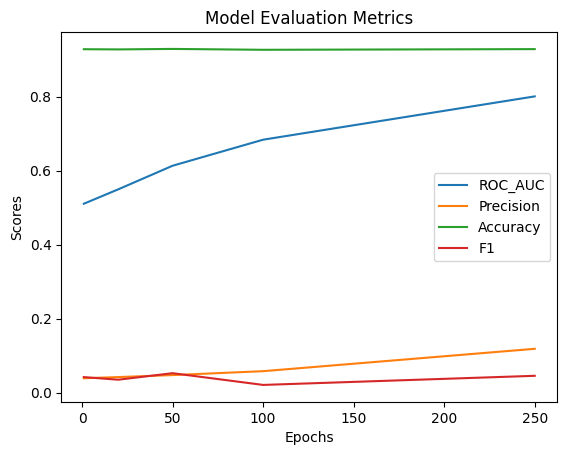

In [11]:
# В качесте лейблов используем список значений эпох
labels = epochs

# Plotting ROC AUC scores
plt.plot(labels, roc_auc_score, label='ROC_AUC')

# Plotting precision scores
plt.plot(labels, precision, label='Precision')

# Plotting accuracy scores
plt.plot(labels, accuracy, label='Accuracy')

# Plotting F1
plt.plot(labels, f1, label='F1')

# Добавляем легенду, лейблы и название
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Scores')
plt.title('Model Evaluation Metrics')

# Отрисовываем график
plt.show()

Далее рассмотрим  метод predict_target(). Основной вариант использования pykeen.predict.predict_target() — прогнозирование ссылок или прогнозирование отношений.

In [12]:
from pykeen.predict import predict_target

for idx, ep in enumerate(epochs):
    pipeline_result = pipeline_results_list[idx]

    # Получаем доступное отношение и сущность
    available_relation = next(iter(countries_dataset.relation_to_id))
    available_entity = next(iter(countries_dataset.entity_to_id))

    # Используем predict_target с доступным отношением и сущностью
    pred = predict_target(
        model=pipeline_result.model,
        relation=available_relation,
        head=available_entity,
        triples_factory=pipeline_result.training,
    )

    pred_filtered = pred.filter_triples(countries_dataset.training)
    pred_annotated = pred_filtered.add_membership_columns(validation=countries_dataset.validation, testing=countries_dataset.testing)
    pred_df = pred_annotated.df[['tail_label', 'score']]
    print(f'Результат при вычислении {ep} эпох')
    print(pred_df)
    print('__________________________')


Результат при вычислении 1 эпох
          tail_label      score
143       martinique  83.225182
96         guatemala  76.590172
122           kosovo  69.273865
158          myanmar  67.321686
231           sweden  61.568439
..               ...        ...
173  northern_europe -61.502663
222  southern_africa -61.912941
8           anguilla -66.707008
132        lithuania -67.442352
50             china -69.859322

[269 rows x 2 columns]
__________________________
Результат при вычислении 20 эпох
           tail_label      score
116             japan  77.045273
126            latvia  66.581688
179             palau  63.806797
49              chile  60.589691
78   falkland_islands  56.354527
..                ...        ...
153          mongolia -55.037544
84   french_polynesia -56.582275
113             italy -60.490192
220       south_korea -71.789307
232       switzerland -73.920486

[269 rows x 2 columns]
__________________________
Результат при вычислении 50 эпох
                    

Попробуйте обучыить другую модель. Примените обученную модель к другому датасету. Проанализируйте результаты. Хорошим вариантом будет преднамеренно удалить существующую связку и исследовать работу модели на предсказании удаленной связи.

# TransE

In [ ]:
import pykeen
import torch
import matplotlib.pyplot as plt
from pykeen.pipeline import pipeline
from pykeen.evaluation import ClassificationEvaluator
from pykeen.datasets import Countries
from pykeen.models import TransE

# Загрузка графового датасета Countries
Countries_dataset = Countries()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Объявим переменные для хранения рассчитанных метрик
roc_auc_score = []
precision = []
accuracy = []
f1 = []

# Переменная для хранения различных пайплайнов pykeen
pipeline_results_list = []
evaluator = ClassificationEvaluator()

# Список значений количества эпох
epochs = [1, 20, 50, 100, 250]

for epoch in epochs:
    # Обучаем модель TransE
    pipeline_results = pipeline(
        model=TransE,
        dataset=Countries_dataset,
        training_kwargs=dict(num_epochs=epoch),
        device=device
    )

    # Сохраняем обученную модель
    pipeline_results_list.append(pipeline_results)

    model = pipeline_results.model
    # Рассчитываем метрики для обученной модели и датасета Countries
    metrics = evaluator.evaluate(model, Countries_dataset.testing.mapped_triples,
                                 additional_filter_triples=[Countries_dataset.training.mapped_triples,
                                                            Countries_dataset.validation.mapped_triples])

    # Сохраняем рассчитанные метрики
    roc_auc_score.append(metrics.get_metric('roc_auc_score'))
    precision.append(metrics.get_metric('average_precision_score'))
    accuracy.append(metrics.get_metric('accuracy_score'))
    f1.append(metrics.get_metric('f1_score'))

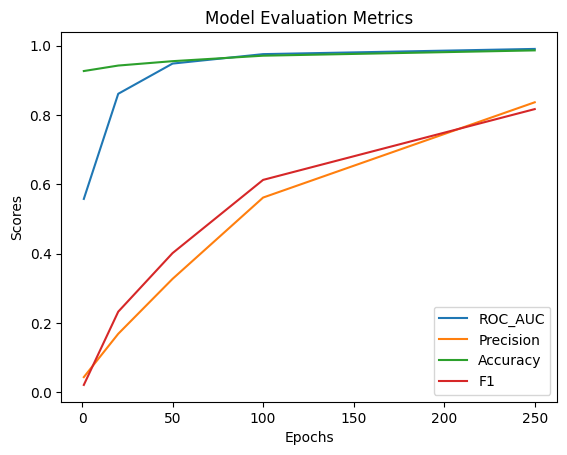

In [14]:
# В качестве лейблов используем список значений эпох
labels = epochs

# Plotting ROC AUC scores
plt.plot(labels, roc_auc_score, label='ROC_AUC')

# Plotting precision scores
plt.plot(labels, precision, label='Precision')

# Plotting accuracy scores
plt.plot(labels, accuracy, label='Accuracy')

# Plotting F1
plt.plot(labels, f1, label='F1')

# Добавляем легенду, лейблы и название
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Scores')
plt.title('Model Evaluation Metrics')

# Отрисовываем график
plt.show()

In [15]:
from pykeen.predict import predict_target

for idx, ep in enumerate(epochs):
    pipeline_result = pipeline_results_list[idx]

    # Получаем доступное отношение и сущность
    available_relation = next(iter(countries_dataset.relation_to_id))
    available_entity = next(iter(countries_dataset.entity_to_id))

    # Используем predict_target с доступным отношением и сущностью
    pred = predict_target(
        model=pipeline_result.model,
        relation=available_relation,
        head=available_entity,
        triples_factory=pipeline_result.training,
    )

    pred_filtered = pred.filter_triples(countries_dataset.training)
    pred_annotated = pred_filtered.add_membership_columns(validation=countries_dataset.validation, testing=countries_dataset.testing)
    pred_df = pred_annotated.df[['tail_label', 'score']]
    print(f'Результат при вычислении {ep} эпох')
    print(pred_df)
    print('__________________________')

Результат при вычислении 1 эпох
              tail_label      score
0            afghanistan  -6.192972
262    wallis_and_futuna  -6.948261
196              réunion  -7.700821
107            indonesia  -7.730798
4         american_samoa  -7.771756
..                   ...        ...
19               bahrain -10.918293
165            nicaragua -10.922810
230            swaziland -10.945824
9    antigua_and_barbuda -11.452105
100               guyana -11.489244

[269 rows x 2 columns]
__________________________
Результат при вычислении 20 эпох
                       tail_label      score
0                     afghanistan  -6.668587
262             wallis_and_futuna  -7.909776
2                         albania  -7.984665
43                 cayman_islands  -8.199989
45                central_america  -8.351480
..                            ...        ...
64                       dominica -11.589756
117                        jersey -11.693492
255  united_states_virgin_islands -11.856720
19